### **Importing Libraries**

In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import nltk
# nltk.download('punkt')
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import string
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **Importing and Cleaning Dataset**

In [2]:
with open('./datasets/Auguste_Maquet.txt', 'r', encoding='utf-8') as file:
    corpus = file.read()

print("Dataset Loaded")

corpus = corpus.lower()
clean_text = sent_tokenize(corpus)
translator = str.maketrans('', '', string.punctuation)
clean_text = [sentence.translate(translator) for sentence in clean_text]
# print(len(clean_text))

Dataset Loaded


### **Tokenization and Emmbedding**

In [3]:
tokenized_corpus = [word_tokenize(sentence) for sentence in clean_text]
word_to_ind = {}
for i in range(len(tokenized_corpus)):
    token_arr = tokenized_corpus[i]
    
    #Vocabulary
    for tokken in token_arr:
        if tokken not in word_to_ind:
            word_to_ind[tokken] = len(word_to_ind)
    
    token_arr = ['<sos>'] * 5 + token_arr + ['<eos>'] * 5
    tokenized_corpus[i] = token_arr

# print(tokenized_corpus[2])
word_to_ind["<sos>"] = len(word_to_ind)
word_to_ind["<eos>"] = len(word_to_ind)
# print(len(word_to_ind))
print("Tokanized the input")


word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

print("Prepare Word Embeddings")

Tokanized the input
Prepare Word Embeddings


### **Test-Train Split**

In [4]:
train_val_data, test_data = train_test_split(tokenized_corpus, test_size=0.2)

train_data, validation_data = train_test_split(train_val_data, test_size=0.125)

# Print the sizes of each set
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")


Training data size: 24571
Validation data size: 3511
Test data size: 7021


### **Neural Network Model**

In [5]:
class NeuralLM(nn.Module):
    def __init__(self, emb_dim, hidden_size, context_size, vocab_size, pretrained_embeddings,dropout_rate):
        super(NeuralLM, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.context_size = context_size
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings), freeze=True)
        #Model Layers
        self.l1 = torch.nn.Linear(self.context_size * self.emb_dim, self.hidden_size)
        self.a1 = torch.nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.l2 = torch.nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, inp):
        #Prepairing Embeddings
        inp = self.embeddings(inp)
        inp = inp.view(inp.size(1), -1) 
        # print(inp.shape)
        
        inp = self.l1(inp)
        inp = self.a1(inp)
        inp = self.dropout(inp)
        inp = self.l2(inp)
        return inp


### **Creating Datasets**

In [6]:
class EntityDataset(torch.utils.data.Dataset):
    def __init__(self, context_indices, next_word_indices):
        self.context_indices = context_indices
        self.next_word_indices = next_word_indices

    def __len__(self):
        return len(self.next_word_indices)
    
    def __getitem__(self, index):
        return torch.tensor(self.context_indices[index]), torch.tensor(self.next_word_indices[index])


### **Creating Input**

In [7]:
N_Gram = 5

def process_sentences(sentences, word_to_index, context_size):
    def words_to_indices(words, word_to_index):
        return [word_to_index.get(word, 0) for word in words]  # Default to 0 if word not in vocab

    context_indices = []
    central_word_indices = []

    for sentence in sentences:
        word_indices = words_to_indices(sentence, word_to_index)

        for i in range(len(sentence) - context_size):
            context_window = word_indices[i:i + context_size]
            context_indices.append(context_window)
            central_word_indices.append(word_to_index.get(sentence[i + context_size], 0))

    return context_indices, central_word_indices


train_gram_inp, train_cen_inp = process_sentences(train_data, word_to_ind, N_Gram)
val_gram_inp, val_cen_inp = process_sentences(validation_data, word_to_ind, N_Gram)
test_gram_inp, test_cen_inp = process_sentences(test_data, word_to_ind, N_Gram)

print(len(train_cen_inp))


841510


### **Train Model**

In [9]:
dataset_train = EntityDataset(train_gram_inp, train_cen_inp)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128)

dataset_val = EntityDataset(val_gram_inp, val_cen_inp)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128)

pretrained_embeddings = word2vec_model.wv.vectors

model = NeuralLM(100, 300, N_Gram, len(word_to_ind), pretrained_embeddings,dropout_rate=0.3)
model.to(device)

num_epochs = 5
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
perp_vis_t = []
perp_vis_val = []

with open('2022101096_LM1_Train_Perplexity.txt', 'w') as train_file, open('2022101096_LM1_Validation_Perplexity.txt', 'w') as val_file:
     
    train_file.write(f'Epoch\tBatch\tPerplexity\n')
    val_file.write(f'Epoch\tBatch\tPerplexity\n')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_index, batch in enumerate(dataloader_train):
            context_words, target_words = batch
            trans_context = torch.transpose(context_words,0,1)
            trans_context = trans_context.to(device)
            target_words = target_words.to(device)
            
            outputs = model(trans_context) 
            outputs = outputs.view(-1, outputs.size(-1))
            target_words = target_words.view(-1)
            
            loss = criterion(outputs, target_words)
            loss.backward()  
            optimizer.step()  
            optimizer.zero_grad() 
            
            total_loss += loss.item()
            batch_perplexity_t = math.exp(loss.item())
                    
            train_file.write(f'{epoch+1}\t{batch_index+1}\t{batch_perplexity_t:.4f}\n')

        avg_train_loss = total_loss / len(dataloader_train)
        train_perplexity = math.exp(avg_train_loss)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_index, batch in enumerate(dataloader_val):
                context_words, target_words = batch
                trans_context = torch.transpose(context_words,0,1)
                trans_context = trans_context.to(device)
                target_words = target_words.to(device)
                
                outputs = model(trans_context)
                outputs = outputs.view(-1, outputs.size(-1))
                target_words = target_words.view(-1)
                
                loss = criterion(outputs, target_words)
                total_val_loss += loss.item()
                batch_perplexity = math.exp(loss.item())
                    
                val_file.write(f'{epoch+1}\t{batch_index+1}\t{batch_perplexity:.4f}\n')
                
                _, predicted = torch.max(outputs, 1)  
                total += target_words.size(0)
                correct += (predicted == target_words).sum().item()
        
        avg_val_loss = total_val_loss / len(dataloader_val)
        val_perplexity = math.exp(avg_val_loss)
        accuracy = 100 * correct / total   

        perp_vis_t.append(train_perplexity)
        perp_vis_val.append(val_perplexity)
    
        train_file.write(f'End of Epoch {epoch+1} - Average Train Perplexity: {train_perplexity:.4f}\n')
        val_file.write(f'End of Epoch {epoch+1} - Average Val Perplexity: {val_perplexity:.4f}\n')

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}, Val Loss: {avg_val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}, Val Accuracy: {accuracy:.2f}%')
        
print("Training and Validation Complete.")


Epoch [1/5], Train Loss: 6.8691, Train Perplexity: 962.0590, Val Loss: 6.3108, Val Perplexity: 550.4783, Val Accuracy: 14.62%
Epoch [2/5], Train Loss: 6.2815, Train Perplexity: 534.5713, Val Loss: 6.1533, Val Perplexity: 470.2693, Val Accuracy: 14.62%
Epoch [3/5], Train Loss: 6.1727, Train Perplexity: 479.4604, Val Loss: 6.0880, Val Perplexity: 440.5519, Val Accuracy: 14.62%
Epoch [4/5], Train Loss: 6.1187, Train Perplexity: 454.2687, Val Loss: 6.0540, Val Perplexity: 425.8210, Val Accuracy: 14.62%
Epoch [5/5], Train Loss: 6.0868, Train Perplexity: 439.9962, Val Loss: 6.0322, Val Perplexity: 416.6157, Val Accuracy: 14.62%
Training and Validation Complete.


### **Evaluate Model**

In [10]:
print("Testing Begins")
dataset_test = EntityDataset(test_gram_inp, test_cen_inp)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128)

model.eval()
correct = 0
total = 0
total_loss = 0
total_tokens = 0
criteria = nn.CrossEntropyLoss()

with open('2022101096_LM1_Test_Perplexity.txt', 'w') as f:
    total_loss = 0
    f.write(f'Batch\tPerplexity\n')

    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader_test):
            context_words, target_words = batch
            trans_context = torch.transpose(context_words,0,1)
            trans_context = trans_context.to(device)
            target_words = target_words.to(device)

            outputs = model(trans_context)
            outputs = outputs.view(-1, outputs.size(-1))
            target_words = target_words.view(-1)

            loss = criterion(outputs, target_words)
            total_loss += loss.item()

            perplexity = math.exp(loss.item())

            f.write(f'{batch_index+1}\t{perplexity:.4f}\n')

        average_perplexity = math.exp(total_loss / len(dataloader_test))
        f.write(f'Average perplexity:\t{average_perplexity:.4f}\n')

    print(f'Average Perplexity: {average_perplexity:.4f}')


Testing Begins
Average Perplexity: 427.5120


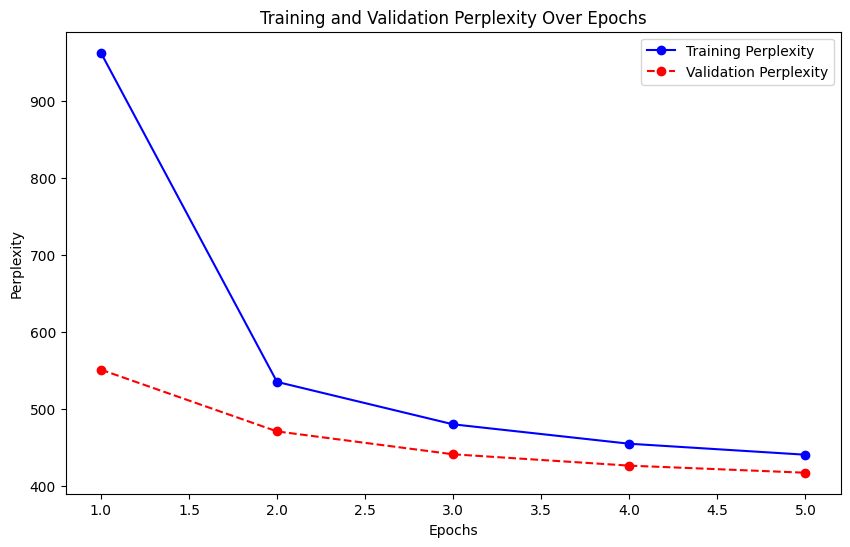

In [11]:
epochs = range(1, len(perp_vis_t) + 1)  # Assuming each entry corresponds to an epoch

plt.figure(figsize=(10, 6))
plt.plot(epochs, perp_vis_t, marker='o', linestyle='-', color='blue', label='Training Perplexity')
plt.plot(epochs, perp_vis_val, marker='o', linestyle='--', color='red', label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity Over Epochs')
plt.legend()
plt.savefig('perplexity_plot.png')
# plt.show()


# Save the entire model
torch.save(model, 'model/model_LM1.pth')